In [10]:
library(IRdisplay)
display_html("<style>.container { width:95% !important; }</style>")

In [3]:
library("dplyr")
library("Seurat")
library("patchwork")
library("Matrix")
library("biomaRt") 
library("ggplot2")
library("hdf5r") 
library("harmony")  
library("presto") 

# INDEX
[Import data](#Import-data)

[Adult mouse](#Adult-mouse)

# Import data

In [4]:
grafts <- readRDS('/grafts.rds')

In [ ]:
grafts_subset <- subset(grafts, subset = annotation_markers2 != 'Astrocytes')

# Adult mouse

In [27]:
adult_mouse <- Load10X_Spatial(
                          "/mnt/projects/labs/CLAB/PROJECT_GRAFTS/Visium_datasets/Visium_inputFiles_MouseAdult/",
                          filename = "V1_Mouse_Brain_Sagittal_Anterior_filtered_feature_bc_matrix.h5",
                          assay = "Spatial")   

In [14]:
adult_mouse <- SCTransform(adult_mouse, assay = "Spatial", verbose = FALSE)

#### Dimesionality reduction

In [ ]:
adult_mouse <- RunPCA(adult_mouse, assay = "SCT", verbose = FALSE)
adult_mouse <- FindNeighbors(adult_mouse, reduction = "pca", dims = 1:50)
adult_mouse <- FindClusters(adult_mouse, verbose = FALSE)
adult_mouse <- RunUMAP(adult_mouse, reduction = "pca", dims = 1:50)

### Integration with single-cell data

In [ ]:
# capitalyze gene names 
rownames(adult_mouse@assays$Spatial) <- toupper(rownames(adult_mouse@assays$Spatial))   
rownames(adult_mouse@assays$SCT) <- toupper(rownames(adult_mouse@assays$SCT))
grafts_subset <- JoinLayers(grafts_subset, assay = 'RNA')

In [ ]:
grafts_subset_common_adult <- grafts_subset
common_genes_adult <- as.character(intersect(rownames(grafts_subset_common_adult@assays$RNA), rownames(adult_mouse@assays$Spatial)))

DefaultAssay(grafts_subset_common_adult) <- 'RNA'
grafts_subset_common_adult <- subset(grafts_subset, feature = common_genes_adult)
grafts_subset_common_adult <- SCTransform(grafts_subset_common_adult, assay = "RNA", new.assay.name = "SCT", verbose = TRUE)

#### mouse genes subset

In [ ]:
adult_mouse@assays$SCT <- NULL

DefaultAssay(adult_mouse) <- 'Spatial'
adult_mouse <- subset(adult_mouse, features = common_genes_adult)

In [ ]:
adult_mouse <- SCTransform(adult_mouse, assay = "Spatial", verbose = FALSE)
adult_mouse <- RunPCA(adult_mouse, assay = "SCT", verbose = FALSE)
adult_mouse <- FindNeighbors(adult_mouse, reduction = "pca", dims = 1:50)
adult_mouse <- FindClusters(adult_mouse, verbose = FALSE)
adult_mouse <- RunUMAP(adult_mouse, reduction = "pca", dims = 1:50)

### Spatial transfer 

In [ ]:
anchors <- FindTransferAnchors(reference = grafts_subset_common_adult, query = adult_mouse, normalization.method = "SCT", k.anchor = 20,
                               recompute.residuals = FALSE, dims = 1:50)
predictions.assay <- TransferData(anchorset = anchors, refdata = grafts_subset_common_adult$annotation_markers2, prediction.assay = TRUE,
    weight.reduction = adult_mouse[["pca"]], dims = 1:50)
adult_mouse[["predictions"]] <- predictions.assay

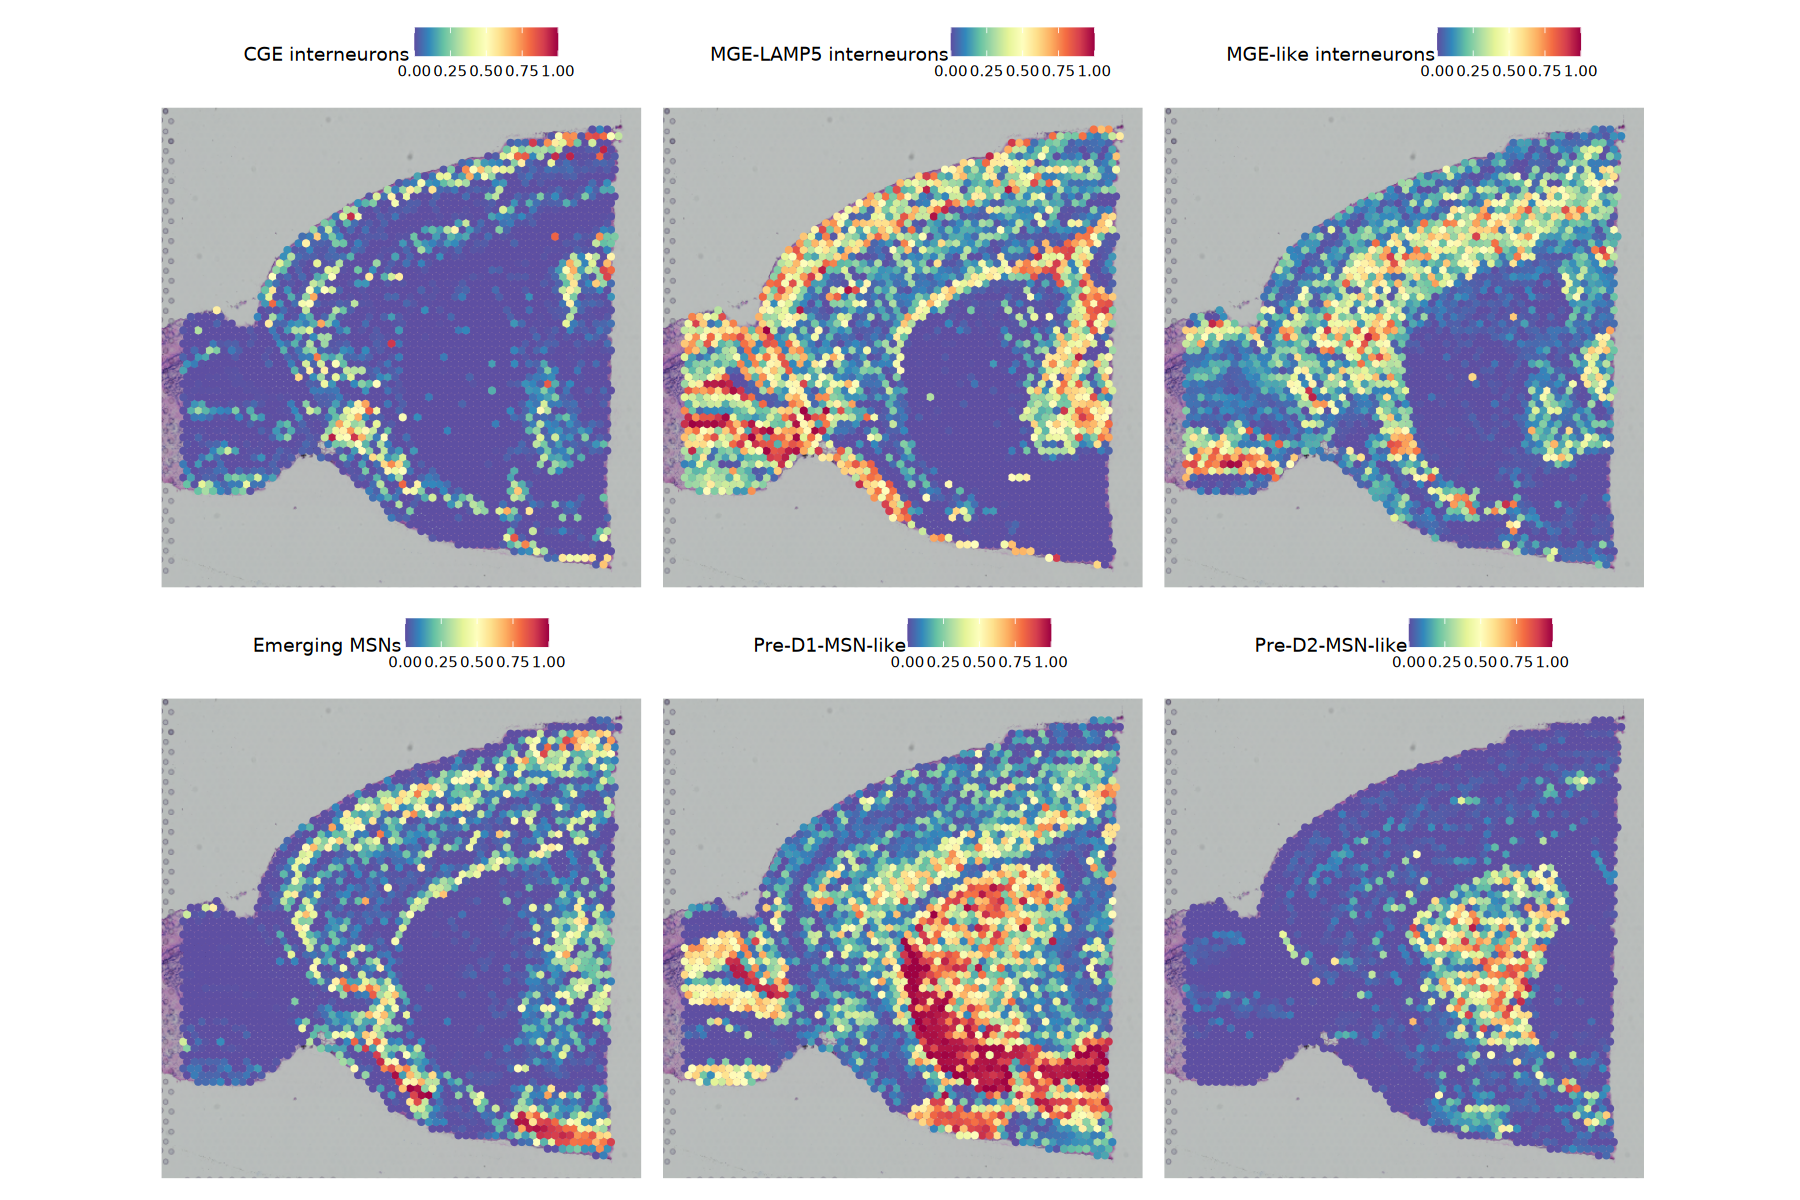

In [179]:
DefaultAssay(adult_mouse) <- "predictions"
SpatialFeaturePlot(adult_mouse, features = c('CGE interneurons', 'MGE-LAMP5 interneurons', 'MGE-like interneurons', 'Emerging MSNs',
                                            'Pre-D1-MSN-like', 'Pre-D2-MSN-like'), pt.size.factor = 1.6, ncol = 3, crop = TRUE,
                  stroke = FALSE, keep.scale = 'all', combine = T) +
    theme(strip.text = element_text(size = 26))